In [67]:
import requests
import pandas as pd
import json
import numpy as np
import os
from datetime import timedelta
from kloppy import skillcorner
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter
from urllib.request import urlopen
from highlight_text import fig_text

from PIL import Image

from mplsoccer import PyPizza, add_image, FontManager


# Setup pitch and plot
from mplsoccer import Pitch
#from mplsoccer.pitch import Pitch ,VerticalPitch

# username = "XXX"
# password = "XXX"


# from skillcorner.client import SkillcornerClient
# client=SkillcornerClient(username=username,password=password)

def time_to_seconds(time_str):
    if time_str is None:
        return 90 * 60  # 120 minutes = 7200 seconds
    h, m, s = map(int, time_str.split(':'))
    return h * 3600 + m * 60 + s

font_normal = FontManager('https://raw.githubusercontent.com/googlefonts/roboto/main/'
                          'src/hinted/Roboto-Regular.ttf')
font_italic = FontManager('https://raw.githubusercontent.com/googlefonts/roboto/main/'
                          'src/hinted/Roboto-Italic.ttf')
font_bold = FontManager('https://raw.githubusercontent.com/google/fonts/main/apache/robotoslab/'
                        'RobotoSlab[wght].ttf')


In [3]:
def load_matches(matches_json_path):

    with open(matches_json_path, "r") as f:
        matches_json = json.load(f)

    match_ids = [match["id"] for match in matches_json]

    all_tracking = []

    for match_id in match_ids:
        tracking_data_github_url = f'https://media.githubusercontent.com/media/SkillCorner/opendata/741bdb798b0c1835057e3fa77244c1571a00e4aa/data/matches/{match_id}/{match_id}_tracking_extrapolated.jsonl'
        
        dataset = skillcorner.load(
            meta_data=f'https://raw.githubusercontent.com/SkillCorner/opendata/741bdb798b0c1835057e3fa77244c1571a00e4aa/data/matches/{match_id}/{match_id}_match.json',
            raw_data=tracking_data_github_url,
            # Optional arguments,
            coordinates="skillcorner",
            include_empty_frames=False)

        all_tracking.append(dataset)

    all_de_dfs = []

    for match_id in match_ids:
        url = f"https://raw.githubusercontent.com/SkillCorner/opendata/master/data/matches/{match_id}/{match_id}_dynamic_events.csv"
        try:
            de_match = pd.read_csv(url)
            all_de_dfs.append(de_match)
        except Exception as e:
            print(f"Failed to load dynamic events for match {match_id}: {e}")

    de_all_matches = pd.concat(all_de_dfs, ignore_index=True)
    
    return all_tracking, de_all_matches
        

In [4]:
# Load matches

matches_json_path = os.path.join(os.path.dirname(os.getcwd()), "data/matches.json")
all_tracking, de_all_matches = load_matches(matches_json_path)

C:\Users\g4a4b\AppData\Local\Temp\ipykernel_20032\822448290.py:27: DtypeWarning: Columns (75,77,184,264) have mixed types. Specify dtype option on import or set low_memory=False.
  de_match = pd.read_csv(url)
C:\Users\g4a4b\AppData\Local\Temp\ipykernel_20032\822448290.py:27: DtypeWarning: Columns (276) have mixed types. Specify dtype option on import or set low_memory=False.
  de_match = pd.read_csv(url)


In [6]:
# ------------- OFF-BALL RUN EVENTS ANALYSIS ---------------------

def untargeted_percentage(de_all_matches, all_tracking):

    # Get off-ball events
    off_ball_events = de_all_matches[de_all_matches["event_type_id"] == 1]
    print(f"Number of off-ball events: {off_ball_events.shape[0]}")

    # Get the total minutes played per match and sum across all matches
    total_duration = timedelta(0)
    for dataset in all_tracking:
        for period in dataset.metadata.periods:
            period_duration = period.end_timestamp - period.start_timestamp
            total_duration += period_duration
    print(f"Total played: {total_duration.total_seconds()/60:.1f} minutes")
    total_minutes = total_duration.total_seconds() / 60

    # Group by event_subtype
    off_ball_events_grouped = off_ball_events.groupby("event_subtype")

    # Calculate stats per each subtype
    off_ball_event_summary = []
    for subtype, group in off_ball_events_grouped:
        targeted_count = group["targeted"].sum()
        total_count = group.shape[0]
        untargeted_count = total_count - targeted_count
        # per90 scaled values
        total_per90 = (total_count * (90 / total_minutes))
        untargeted_per90 = (untargeted_count * (90 / total_minutes))
        untargeted_proportion = untargeted_count / total_count if total_count > 0 else 0
        print(f"Subtype: {subtype} Total: {total_count} ({total_per90:.2f}/90min), Untargeted: {untargeted_count} ({untargeted_per90:.2f}/90min, {untargeted_proportion:.2%})")
        # Save these values for later use
        off_ball_event_summary.append({
            "subtype": subtype,
            "total": total_count,
            "total_per90": total_per90,
            "untargeted": untargeted_count,
            "untargeted_per90": untargeted_per90,
            "untargeted_proportion": untargeted_proportion
        })

    # Convert to DataFrame for easier handling
    off_ball_event_stats_df = pd.DataFrame(off_ball_event_summary)

    # Get the overall stats too
    overall_total_count = off_ball_events.shape[0]
    overall_targeted_count = off_ball_events["targeted"].sum()
    overall_untargeted_count = overall_total_count - overall_targeted_count
    totalper90 = (overall_total_count * (90 / total_minutes))
    untargetedper90 = (overall_untargeted_count * (90 / total_minutes))
    untargetedproportion = overall_untargeted_count / overall_total_count if overall_total_count > 0 else 0
    print(f"Overall Off-Ball Events - Total: {overall_total_count} ({totalper90:.2f}/90min), Untargeted: {overall_untargeted_count} ({untargetedper90:.2f}/90min, {untargetedproportion:.2%})")

    return off_ball_event_stats_df

In [7]:
# Calculate percentage of untargeted off-ball runs by subtype

untargeted_percentage_df = untargeted_percentage(de_all_matches, all_tracking)

Number of off-ball events: 5002
Total played: 985.6 minutes
Subtype: behind Total: 363 (33.15/90min), Untargeted: 208 (18.99/90min, 57.30%)
Subtype: coming_short Total: 701 (64.01/90min), Untargeted: 457 (41.73/90min, 65.19%)
Subtype: cross_receiver Total: 423 (38.63/90min), Untargeted: 293 (26.76/90min, 69.27%)
Subtype: dropping_off Total: 631 (57.62/90min), Untargeted: 386 (35.25/90min, 61.17%)
Subtype: overlap Total: 153 (13.97/90min), Untargeted: 93 (8.49/90min, 60.78%)
Subtype: pulling_half_space Total: 148 (13.52/90min), Untargeted: 113 (10.32/90min, 76.35%)
Subtype: pulling_wide Total: 344 (31.41/90min), Untargeted: 190 (17.35/90min, 55.23%)
Subtype: run_ahead_of_the_ball Total: 1378 (125.84/90min), Untargeted: 903 (82.46/90min, 65.53%)
Subtype: support Total: 751 (68.58/90min), Untargeted: 525 (47.94/90min, 69.91%)
Subtype: underlap Total: 110 (10.05/90min), Untargeted: 78 (7.12/90min, 70.91%)
Overall Off-Ball Events - Total: 5002 (456.78/90min), Untargeted: 3246 (296.42/90min,

In [8]:
def plot_untargeted_percentage(untargeted_percentage_df, subtype_names_map=None):
    # Copy and sort
    df_plot = untargeted_percentage_df.copy()
    df_plot = df_plot.sort_values("untargeted_proportion", ascending=True)

    if subtype_names_map:
        df_plot["subtype_display"] = df_plot["subtype"].map(subtype_names_map)
    else:
        df_plot["subtype_display"] = df_plot["subtype"]

    plt.figure(figsize=(10, 6))

    # Draw bars with contour (edge)
    plt.barh(
        df_plot["subtype_display"],
        df_plot["untargeted_proportion"],
        color="#00ff1e",
        edgecolor="black",   # contour around each bar
        linewidth=1.5
    )

    # Title and axis labels
    plt.title("Share of Untargeted Runs by Run Type", fontsize=14, fontweight='bold', fontname='Arial')
    plt.xlabel("% untargeted", fontsize=12, fontweight='bold', fontname='Arial')
    plt.ylabel("Subtype", fontsize=12, fontweight='bold', fontname='Arial')

    # Format x-axis as percentages
    plt.gca().xaxis.set_major_formatter(PercentFormatter(xmax=1))
    plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])

    # Remove all spines except left and bottom
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)

    # Remove grid
    plt.grid(False)

    # Y-axis tick labels
    plt.yticks(fontsize=12, fontweight='normal', fontname='Arial')

    plt.xlim(0, 1.0)
    plt.tight_layout()
    plt.show()

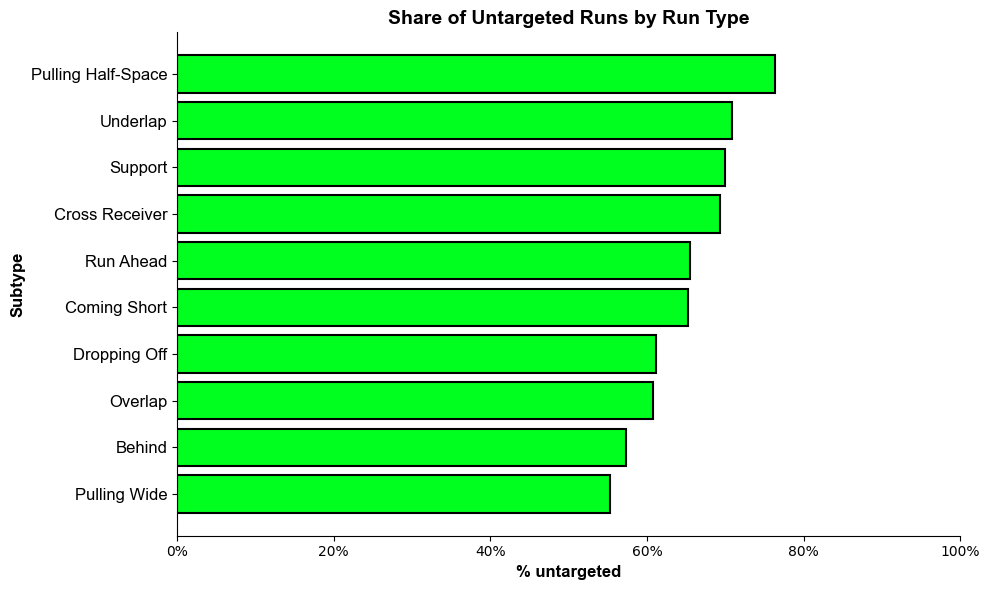

In [9]:
subtype_names_map = {
        "behind": "Behind",
        "coming_short": "Coming Short",
        "cross_receiver": "Cross Receiver",
        "dropping_off": "Dropping Off",
        "overlap": "Overlap",
        "pulling_half_space": "Pulling Half-Space",
        "pulling_wide": "Pulling Wide",
        "run_ahead_of_the_ball": "Run Ahead",
        "support": "Support",
        "underlap": "Underlap"
    }
plot_untargeted_percentage(untargeted_percentage_df, subtype_names_map=subtype_names_map)

In [10]:
def untargeted_runs_team_subtype(de_all_matches, all_tracking):
    # Get untargeted off-ball events
    off_ball_events = de_all_matches[de_all_matches["event_type_id"] == 1]
    untargeted_off_ball_events = off_ball_events[off_ball_events["targeted"] == False]

    # Group untargeted off-ball events by team and subtype
    team_subtype = untargeted_off_ball_events.groupby(
        ['team_id', 'team_shortname', 'event_subtype']).size().reset_index(name='untargeted_count')

    # Dictionary to store total minutes per team
    team_minutes = {}
    for dataset in all_tracking:
        match_duration = timedelta(0)
        for period in dataset.metadata.periods:
            period_duration = period.end_timestamp - period.start_timestamp
            match_duration += period_duration
        match_minutes = match_duration.total_seconds() / 60
        for team in dataset.metadata.teams:
            if team.team_id not in team_minutes:
                team_minutes[team.team_id] = 0
            team_minutes[team.team_id] += match_minutes

    # Merge total minutes into team_subtype DataFrame
    team_subtype['total_minutes'] = team_subtype['team_id'].map(team_minutes)
    
    # Calculate untargeted per90
    team_subtype['untargeted_per90'] = team_subtype['untargeted_count'] / team_subtype['total_minutes'] * 90

    # Pivot the DataFrame to have subtypes as columns and teams as rows
    df_pivot = team_subtype.pivot(
        index='team_shortname', 
        columns='event_subtype', 
        values='untargeted_per90'
        ).fillna(0)

    percentile_df = df_pivot.rank(pct=True) * 100
    
    return df_pivot, percentile_df


In [52]:
df_pivot, percentile_df = untargeted_runs_team_subtype(de_all_matches, all_tracking)
print(df_pivot)

event_subtype       behind  coming_short  cross_receiver  dropping_off  \
team_shortname                                                           
Adelaide United  14.062500     15.937500       15.000000     12.187500   
Auckland FC       7.263587     20.882812       20.882812     12.938264   
Brisbane FC       4.406005     26.436031        8.812010     18.505222   
CC Mariners       4.558578     19.146026        0.911716     15.499164   
Macarthur FC      5.468447     13.671117        8.202670     10.936893   
Melbourne City   20.054356     27.346849       15.952329     32.360438   
Melbourne V FC    5.962290     11.007304       11.924580     15.135043   
Newcastle        12.804878     38.414634        8.231707     21.036585   
Perth Glory       0.881201     21.148825       14.980418     20.267624   
Sydney FC        11.801731     19.354839        9.913454     18.410700   
Wellington P FC   8.564345     19.833221       13.973405     16.227181   
Western United   13.420173     21.7499

In [124]:
def individual_pizza_plot(df_pivot, percentile_df, team1, team2, subtype_names_map, badges_dict=None):
    # Function to create pizza plot for a given team

    values = percentile_df.loc[team1].tolist() # percentile values for slices
    values = [round(v, 1) for v in values] # round to 1 decimal
    # absolute per90 for labels
    per90_values = df_pivot.loc[team1].tolist()
    # params is equal to the subtype names mapped, an intro and the absolute per90 values
    params = [subtype_names_map[subtype] for subtype in percentile_df.columns]

    if team2:
        values2 = percentile_df.loc[team2].tolist() # percentile values for slices
        values2 = [round(v, 1) for v in values2] # round

    baker = PyPizza(
    params=params,                  # list of parameters
    straight_line_color="#F2F2F2",  # color for straight lines
    straight_line_lw=1,             # linewidth for straight lines
    last_circle_lw=1,               # linewidth of last circle
    other_circle_lw=1,              # linewidth for other circles
    other_circle_ls="-.",           # linestyle for other circles
    inner_circle_size=8,            # size of inner circle
    )

    if not team2:

        # plot pizza
        fig, ax = baker.make_pizza(
            values,              # list of values
            figsize=(10, 10),      # adjust figsize according to your need
            param_location=110,  # where the parameters will be added
            kwargs_slices=dict(
                facecolor="cornflowerblue", edgecolor="black",
                zorder=2, linewidth=1
            ),                   # values to be used when plotting slices
            kwargs_params=dict(
                color="#000000", fontsize=10,
                fontproperties=font_normal.prop, va="center"
            ),                   # values to be used when adding parameter
            kwargs_values=dict(
            color="#000000", fontsize=8,
            fontproperties=font_normal.prop, zorder=3,
            bbox=dict(
                edgecolor="#000000", facecolor="cornflowerblue",
                boxstyle="round,pad=0.2", lw=1
                )                   
            )                   # values to be used when adding values            
        )
        # add title
        fig_text(
            0.515, 1,
            f"<{team1}>",
            size=15, fig=fig,
            highlight_textprops=[{"color": '#1A78CF'}],
            ha="center", fontproperties=font_bold.prop, color="#000000"
        )
    
    else:

         # plot pizza
        fig, ax = baker.make_pizza(
            values,              # list of values
            figsize=(10, 10),      # adjust figsize according to your need
            compare_values=values2,  # list of values for comparison
            param_location=110,  # where the parameters will be added
            kwargs_slices=dict(
                facecolor="cornflowerblue", edgecolor="black",
                zorder=2, linewidth=1
            ),                   # values to be used when plotting slices
            kwargs_compare=dict(
                facecolor="#FF9300", edgecolor="#222222",
                zorder=2, linewidth=1,
            ),                   # values to be used when plotting comparison slices
            kwargs_params=dict(
                color="#000000", fontsize=10,
                fontproperties=font_normal.prop, va="center"
            ),                   # values to be used when adding parameter
            kwargs_values=dict(
            color="#000000", fontsize=8,
            fontproperties=font_normal.prop, zorder=3,
            bbox=dict(
                edgecolor="#000000", facecolor="cornflowerblue",
                boxstyle="round,pad=0.2", lw=1
                )                   
            ),                   # values to be used when adding values
            kwargs_compare_values=dict(
        color="#000000", fontsize=8, fontproperties=font_normal.prop, zorder=3,
        bbox=dict(edgecolor="#000000", facecolor="#FF9300", boxstyle="round,pad=0.2", lw=1)
            )
        )

        # add title
        fig_text(
            0.515, 1,
            f"<{team1}> vs <{team2}>",
            size=15, fig=fig,
            highlight_textprops=[{"color": '#1A78CF'}, {"color": '#EE8900'}],
            ha="center", fontproperties=font_bold.prop, color="#000000"
        )

        # add image for team2
        if badges_dict and team2 in badges_dict:
            img = Image.open(badges_dict[team2])
            ax_image = add_image(
                img, fig, left=0.8, bottom=0.9, width=0.13, height=0.127
            )   # these values might differ when you are plotting

    # add image if badges_dict is provided
    if badges_dict and team1 in badges_dict:
        img = Image.open(badges_dict[team1])
        ax_image = add_image(
            img, fig, left=0.1, bottom=0.9, width=0.13, height=0.127
        )   # these values might differ when you are plotting
    
    fig.text(
    0.515, 0.96,
    "Untargeted Runs Profile",
    size=13,
    ha="center", fontproperties=font_bold.prop, color="#000000"
    )

    fig.text(
    0.515, 0.92,
    "Percentile Rank vs A-league teams | Season 2024-25\n",
    size=12,
    ha="center", fontproperties=font_bold.prop, color="#000000"
    )
    

    plt.show()

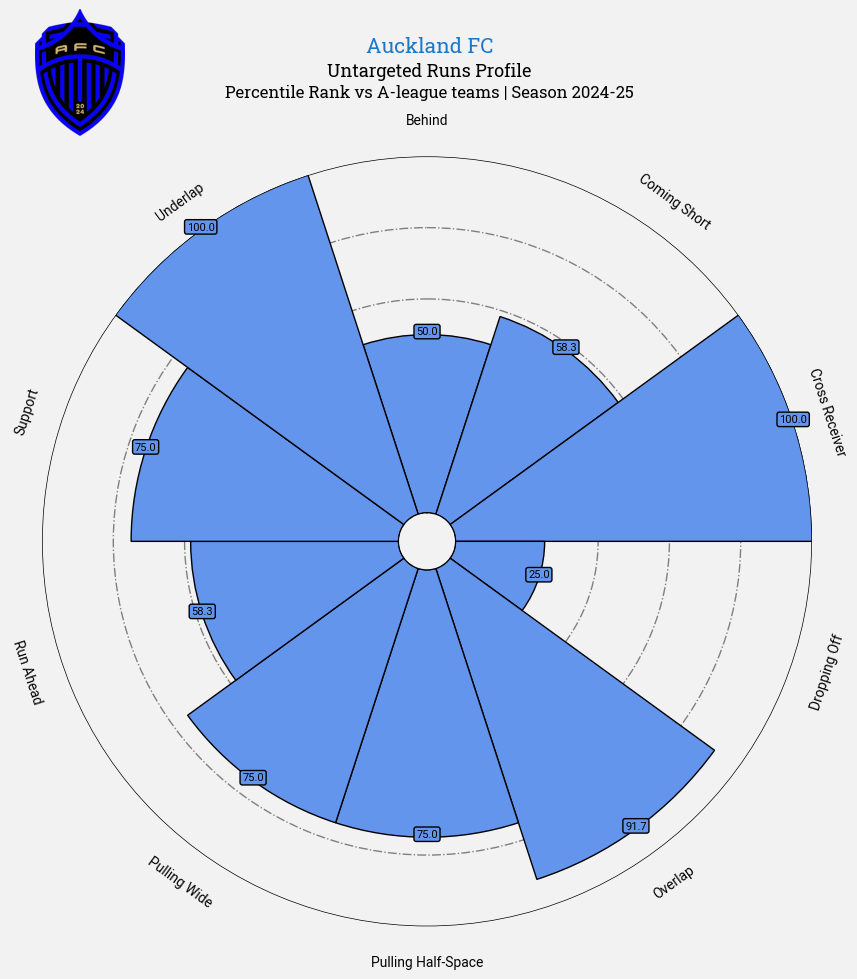

In [122]:
badges_folder = os.path.join(os.path.dirname(os.getcwd()), "badges")
badges_dict = {'Auckland FC': os.path.join(badges_folder, "AucklandFC.png"),
               'Brisbane FC': os.path.join(badges_folder, "BrisbaneFC.png")}

individual_pizza_plot(df_pivot, percentile_df,'Auckland FC', None, subtype_names_map=subtype_names_map, badges_dict=badges_dict)

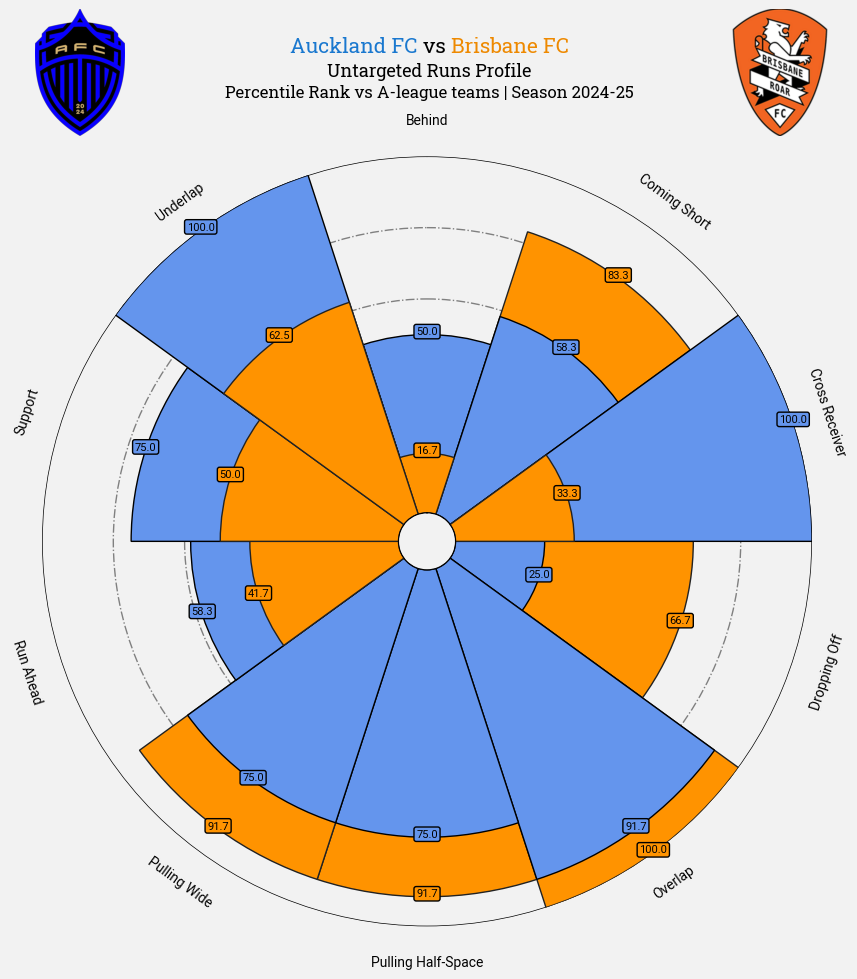

In [125]:
individual_pizza_plot(df_pivot, percentile_df,'Auckland FC', "Brisbane FC", subtype_names_map=subtype_names_map, badges_dict=badges_dict)